# Predicting the 2024 UEFA Euro Using Poisson Distribution

Football predictions have always been a fascinating topic for data scientists and enthusiasts alike. In this project, we leverage the power of the Poisson distribution to forecast the outcomes of the 2024 UEFA European Championship. This method is particularly well-suited for predicting football scores due to the nature of the game, where goals are relatively rare events.

In [1]:
#intalling the necesary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.colors as mcolors
import warnings
warnings.filterwarnings('ignore')

# Data Collection
The first step in our analysis involved gathering historical match data. The dataset sourced from Kaggle contains the results of international football matches starting from the very first official match in 1872 up to 2024.

In [2]:
#Reading the 
df = pd.read_csv('/kaggle/input/international-football-results-from-1872-to-2017/results.csv',sep=',',)
#Dropping matches without final result
df=df[~df['home_score'].isna()]

# ELO Ranking System

The Elo ranking system is a method for calculating the relative skill levels of teams. It is useful for ranking teams based on their performance in previous matches. The Elo rating is dynamic, meaning it changes based on the results of matches, rewarding teams for wins and penalizing them for losses, while also considering the strength of the opponents.

To create our dataset, we need to define some parameters, such as the importance of each tournament in the points exchanged by the Elo ranking system.

In [3]:
#Auxiliary funtions for update the ratings
confederation_tournaments=['AFC Asian Cup','African Cup of Nations','UEFA Euro','Copa América','CONCACAF Championship','Oceania Nations Cup']
confederation_clasification=['UEFA Euro qualification','African Cup of Nations qualification','FC Asian Cup qualification','UEFA Nations League']
def k_value(tournament):
    k=5
    if tournament == 'Friendly':
        k=10
    elif tournament in confederation_clasification:
        k=20
    elif tournament == 'FIFA World Cup qualification':
        k=25
    elif tournament in confederation_tournaments:
        k=40
    elif tournament == 'FIFA World Cup':
        k=50
    return k

def expected_result(loc,aw):
    dr=loc-aw
    we=(1/(10**(-dr/400)+1))
    return [np.round(we,3),1-np.round(we,3)]

def actual_result(loc,aw):
    if loc<aw:
        wa=1
        wl=0
    elif loc>aw:
        wa=0
        wl=1
    elif loc==aw:
        wa=0.5
        wl=0.5
    return [wl,wa]

def calculate_elo(elo_l,elo_v,local_goals,away_goals,tournament):

    k=k_value(tournament)
    wl,wv=actual_result(local_goals,away_goals)
    wel,wev=expected_result(elo_l,elo_v)

    elo_ln=elo_l+k*(wl-wel)
    elo_vn=elo_v+k*(wv-wev)

    return elo_ln,elo_vn,wel,wev

In [4]:
#Calculating the elo points for all historical internatinal matches
current_elo={}
for idx,row in df.iterrows():

    local=row['home_team']
    away=row['away_team']
    local_goals=row['home_score']
    away_goals=row['away_score']
    tournament = row['tournament']


    if local not in current_elo.keys():
        current_elo[local]=1300

    if away not in current_elo.keys():
        current_elo[away]=1300

    elo_l=current_elo[local]
    elo_v=current_elo[away]
    elo_ln,elo_vn, wel,wev=calculate_elo(elo_l,elo_v,local_goals,away_goals,tournament)

    current_elo[local]=elo_ln
    current_elo[away]=elo_vn

    df.loc[idx,'Elo_h_after']=elo_ln
    df.loc[idx,'Elo_a_after']=elo_vn
    df.loc[idx,'Elo_h_before']=elo_l
    df.loc[idx,'Elo_a_before']=elo_v
    df.loc[idx,'probH']=wel
    df.loc[idx,'probA']=wev

Once we have processed the historical data of international matches, we can calculate the final Elo points for each team. This gives us the current Elo ranking, which reflects the latest performance levels of the teams.

In [5]:
elos=pd.concat([df[['date','home_team','Elo_h_after']].rename(columns={'home_team':'Team','Elo_h_after':'Elo'}),df[['date','away_team','Elo_a_after']].rename(columns={'away_team':'Team','Elo_a_after':'Elo'})])
elos.sort_values(by='date', ascending=False,inplace=True)
elos.drop_duplicates('Team',inplace=True)
elos.sort_values(by='Elo', ascending=False, inplace=True)
elos.reset_index(drop=True, inplace=True)
elos['position']=elos.index+1

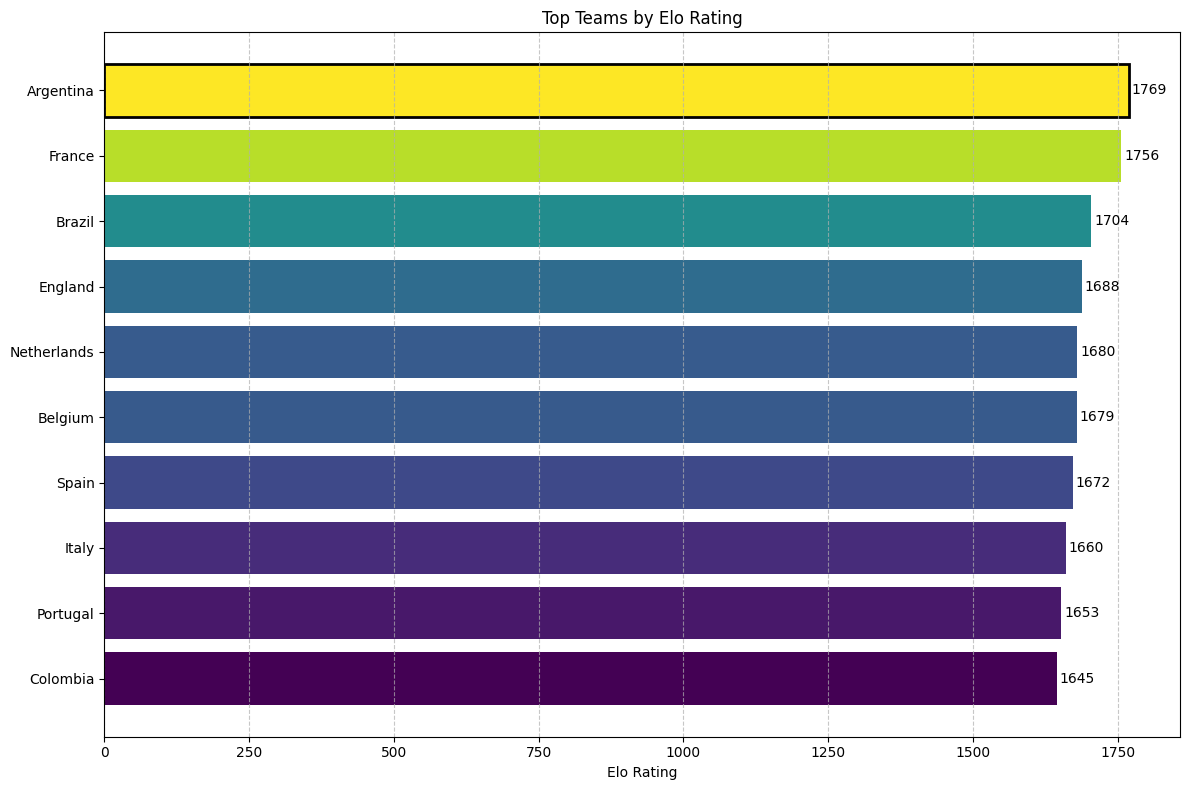

In [6]:
def plot_top_elo(elos, n=10):
    """
    Plots the top n teams by Elo rating in a horizontal bar chart.
    
    Parameters:
    elos (pd.DataFrame): DataFrame containing 'Team' and 'Elo' columns.
    n (int): Number of top teams to display.
    """
    # Sort elos DataFrame by Elo rating in descending order
    elos.sort_values(by='Elo', ascending=False, inplace=True)

    # Select only the top n teams
    top_teams = elos.head(n)

    # Create a color map
    cmap = plt.get_cmap('viridis')
    norm = mcolors.Normalize(vmin=min(top_teams['Elo']), vmax=max(top_teams['Elo']))
    colors = cmap(norm(top_teams['Elo']))

    # Plotting
    plt.figure(figsize=(12, 8))
    bars = plt.barh(top_teams['Team'], top_teams['Elo'], color=colors)
    
    # Add text annotations
    for bar in bars:
        plt.text(
            bar.get_width() + 5, 
            bar.get_y() + bar.get_height() / 2, 
            f'{bar.get_width():.0f}', 
            ha='left', 
            va='center',
            fontsize=10
        )

    # Highlighting the top team
    bars[0].set_edgecolor('black')
    bars[0].set_linewidth(2)

    # Customizing the plot
    plt.xlabel('Elo Rating')
    plt.title('Top Teams by Elo Rating')
    plt.gca().invert_yaxis()  # Invert y-axis to display the highest Elo at the top
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Show plot
    plt.tight_layout()
    plt.show()

# Call the function
plot_top_elo(elos, 10)


We will focus only on the teams participating in the 2024 Euro. Therefore, the ranking would be as follows:

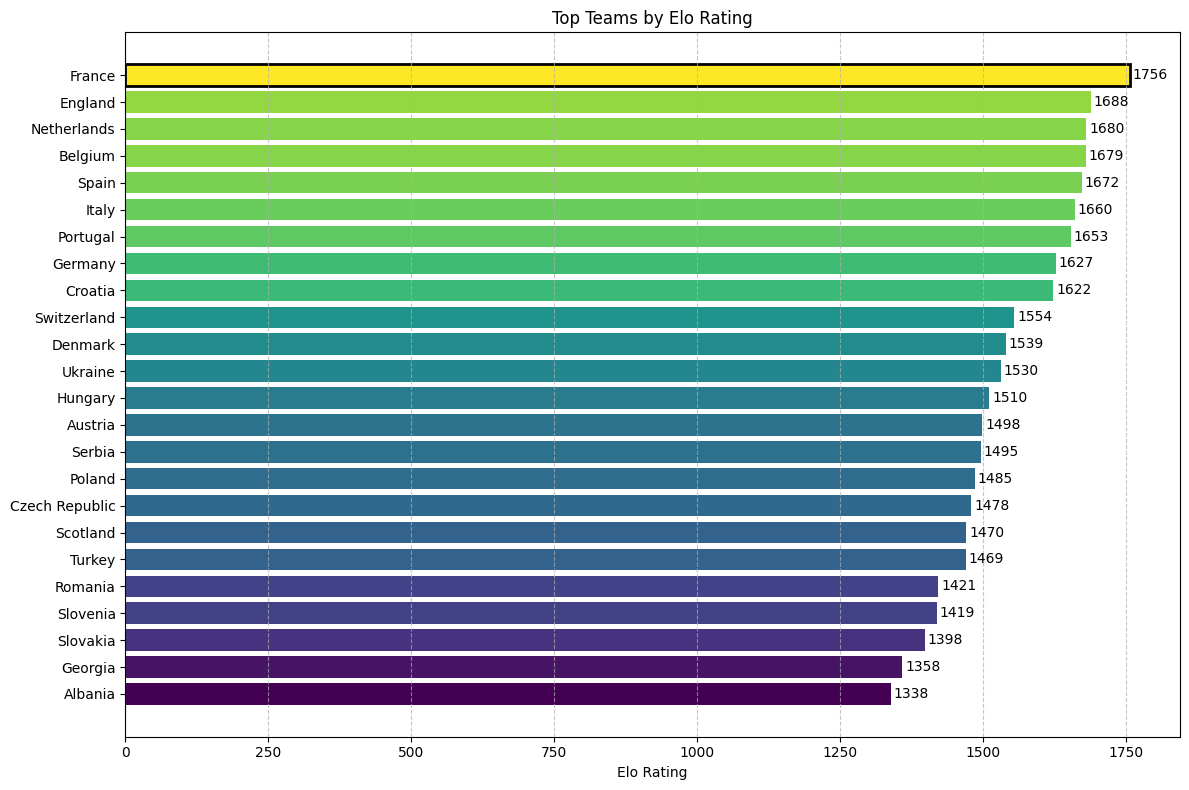

In [7]:
eurocup_teams =[
    "Albania", "Scotland", "Hungary", "Romania",
    "Germany", "Slovakia", "England", "Czech Republic",
    "Austria", "Slovenia", "Italy", "Serbia",
    "Belgium", "Spain", "Netherlands", "Switzerland",
    "Croatia", "France", "Poland", "Turkey",
    "Denmark", "Georgia", "Portugal", "Ukraine"
]

elos_ranking_euro = elos[elos.Team.isin(eurocup_teams)].copy()
plot_top_elo(elos_ranking_euro,24)

Based on this ranking, we can say that France is the favorite to win the Euro, while Albania is the weakest team in the tournament.

One of the problems with international matches is that we don't have the statistics of a league, making it difficult to determine which team has a better attack because it depends on the quality of the opponent. To solve this, and using the same idea as the Elo ranking system above, we can create a ranking for attacking power and defensive power.

In [8]:
def calculate_attdef(Attack_l,Attack_v,Deffend_l,Deffend_v,localGoals,awayGoals, tournament,neutral):
    k=k_value(tournament)
    if neutral==False:
        c=1.27
    else:
        c=1
    ehg=Attack_l*Deffend_v*c
    eag=Attack_v*Deffend_l/c
    Attack_ln=Attack_l+(k/2000)*(localGoals-ehg)
    Attack_vn=Attack_v+(k/2000)*(awayGoals-eag)
    Deffend_ln=Deffend_l+(k/2000)*(awayGoals-eag)
    Deffend_vn=Deffend_v+(k/2000)*(localGoals-ehg)
  
    return Attack_ln,Attack_vn,Deffend_ln,Deffend_vn, ehg, eag

In [9]:
current_att={}
current_def={}
for idx,row in df.iterrows():

    local=row['home_team']
    away=row['away_team']
    local_goals=row['home_score']
    away_goals=row['away_score']
    tournament=row['tournament']
    neutral=row['neutral']

    if local not in current_att.keys():
        current_att[local]=1.3
    if away not in current_att.keys():
        current_att[away]=1.3
    if local not in current_def.keys():
        current_def[local]=1.3
    if away not in current_def.keys():
        current_def[away]=1.3

    att_l=current_att[local]
    att_v=current_att[away]
    def_l=current_def[local]
    def_v=current_def[away]

    att_ln,att_vn, def_ln, def_vn, ehg, eag=calculate_attdef(att_l,att_v,def_l,def_v,local_goals,away_goals, tournament,neutral)

    current_att[local]=att_ln
    current_att[away]=att_vn
    current_def[local]=def_ln
    current_def[away]=def_vn

    df.loc[idx,'att_h_after']=att_ln
    df.loc[idx,'att_a_after']=att_vn
    df.loc[idx,'att_h_before']=att_l
    df.loc[idx,'att_a_before']=att_v
    df.loc[idx,'def_h_after']=def_ln
    df.loc[idx,'def_a_after']=def_vn
    df.loc[idx,'def_h_before']=def_l
    df.loc[idx,'def_a_before']=def_v
    df.loc[idx,'XGhome']=ehg
    df.loc[idx,'XGaway']=eag

In [10]:
attdef=df.copy()
attdef=pd.concat([df[['date','home_team','att_h_after','def_h_after']].rename(columns={'home_team':'Team','att_h_after':'att','def_h_after':'def'}),df[['date','away_team','att_a_after','def_a_after']].rename(columns={'away_team':'Team','att_a_after':'att','def_a_after':'def'})])
attdef.sort_values(by='date', ascending=False,inplace=True)
attdef.drop_duplicates('Team',inplace=True)
attdef.sort_values(by='def', ascending=True,inplace=True)
attdef.reset_index(drop=True, inplace=True)
attdef['def_position']=attdef.index+1
attdef.sort_values(by='att', ascending=False,inplace=True)
attdef.reset_index(drop=True, inplace=True)
attdef['att_position']=attdef.index+1

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_top_att_def(elos, n=10):
    """
    Plot the top teams by attacking and defensive power.

    Parameters:
    elos (pd.DataFrame): DataFrame containing team ratings.
    n (int): Number of top teams to display.
    """
    # Sort elos DataFrame by attacking and defensive ratings
    elos_sorted_att = elos.sort_values(by='att', ascending=False).head(n)
    elos_sorted_def = elos.sort_values(by='def', ascending=True).head(n)

    # Create a color map for both plots
    colors_att = plt.cm.viridis(elos_sorted_att['att'] / max(elos_sorted_att['att']))
    colors_def = plt.cm.viridis(elos_sorted_def['def'] / max(elos_sorted_def['def']))

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot for attacking ratings
    bars_att = ax1.barh(elos_sorted_att['Team'], elos_sorted_att['att'], color=colors_att)
    ax1.set_xlabel('Attacking Power', fontsize=14)
    ax1.set_title('Top Teams by Attacking Power', fontsize=16, weight='bold')
    ax1.invert_yaxis()  # Invert y-axis to display the highest rating at the top
    ax1.grid(axis='x', linestyle='--', alpha=0.7)

    # Add text annotations for attacking ratings
    for bar in bars_att:
        ax1.text(
            bar.get_width() + 0.01, 
            bar.get_y() + bar.get_height() / 2, 
            f'{bar.get_width():.2f}', 
            ha='left', 
            va='center',
            fontsize=12,
            color='black'
        )

    # Plot for defensive ratings
    bars_def = ax2.barh(elos_sorted_def['Team'], elos_sorted_def['def'], color=colors_def)
    ax2.set_xlabel('Defensive Power', fontsize=14)
    ax2.set_title('Top Teams by Defensive Power', fontsize=16, weight='bold')
    ax2.invert_yaxis()  # Invert y-axis to display the highest rating at the top
    ax2.grid(axis='x', linestyle='--', alpha=0.7)

    # Add text annotations for defensive ratings
    for bar in bars_def:
        ax2.text(
            bar.get_width() + 0.01, 
            bar.get_y() + bar.get_height() / 2, 
            f'{bar.get_width():.2f}', 
            ha='left', 
            va='center',
            fontsize=12,
            color='black'
        )

    # Adjust layout
    plt.tight_layout()
    plt.show()


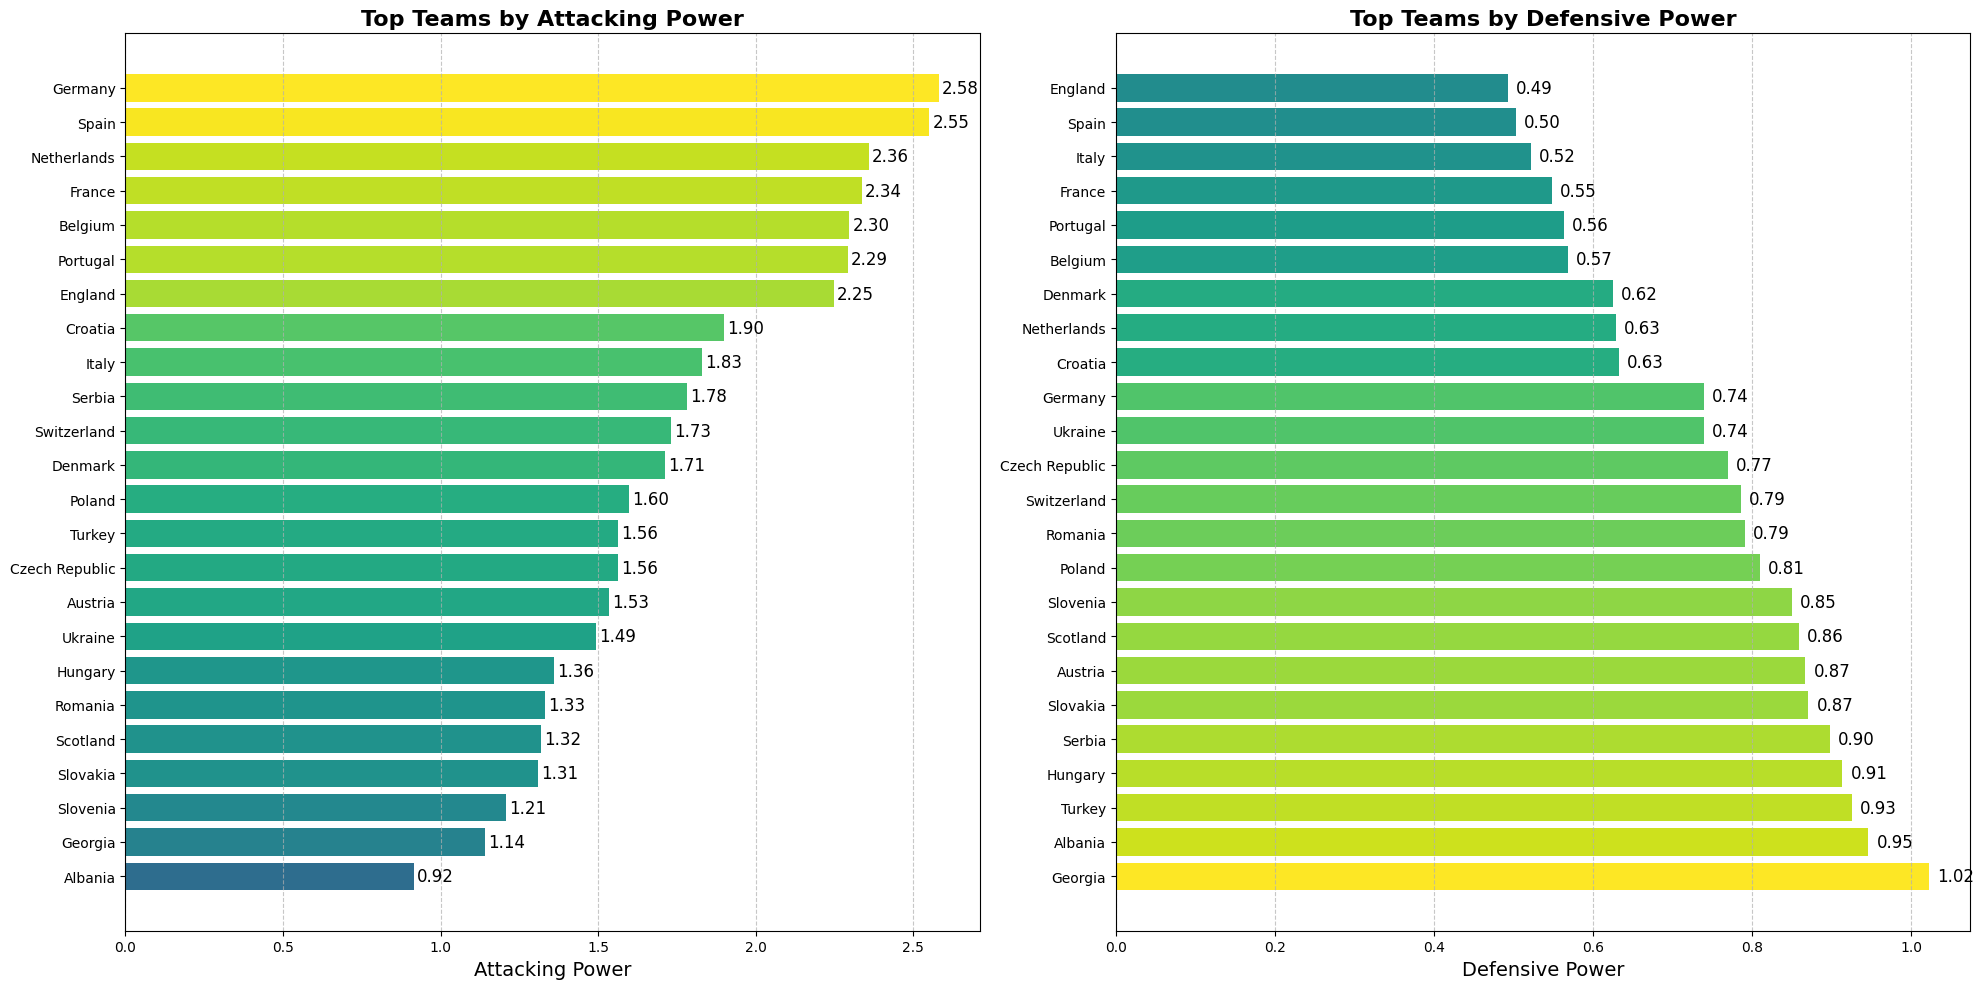

In [12]:
attdef_ranking_europe = attdef[attdef.Team.isin(eurocup_teams)]
plot_top_att_def(attdef_ranking_europe,24)

Based on this ranking, we can conclude that the teams with the best attack are Germany and Spain. The teams with the best defense are England, Spain, and Italy.

# Goals Expected and Poisson Distribution

The best aspect of this ranking is that we can use it to calculate the expected goals in a match. The expected goals for a team can be calculated as:

$$
Expected Goals=
Attacking Power Team×Defensive Power Opponent$$

Additionally, in non-neutral matches, we have to set a parameter for the advantage of the home team. This parameter adjusts the expected goals to account for the home field advantage.

Let see if the results adjust with Expected goals we predicted, for doing that we consider the results of European tournaments of the last 14 years.

In [13]:
#Creating the reference dataset
df2 = df[(df.date>"2010-09-01") & (df.tournament.isin(["UEFA Euro","UEFA Euro qualification","UEFA Nations League"]))].copy()

# Define the bins
bins = np.array([1.5,2.25, 2.5, 2.75, 3,10])  # adjust this to fit your data
df2['total_score'] = df2['away_score'] + df2['home_score']
df2['total_xG']=df2['XGhome']+df2['XGaway']
df2['total_xG_bin'] = pd.cut(df2['total_xG'], bins)

# Group by the bin and calculate the mean of the 'Goals' column
binned_means = df2.groupby('total_xG_bin')['total_score'].agg(["mean","count"])

print(binned_means)

                  mean  count
total_xG_bin                 
(1.5, 2.25]   2.249307    361
(2.25, 2.5]   2.381963    377
(2.5, 2.75]   2.536657    341
(2.75, 3.0]   2.944186    215
(3.0, 10.0]   3.509146    328


We can see that the expected goals we created adjust very well to the real number of goals in the matches. So we can use the poisson distribution to predict the results of the matches

The Poisson distribution is defined by the probability mass function:

𝑃(𝑋=𝑘)=𝜆𝑘𝑒−𝜆𝑘!

where:

𝑃(𝑋=𝑘) is the probability of 𝑘 goals being scored, λ is the average number of goals scored in a match.

In our context, 𝜆 represents the average number of goals a team is expected to score.

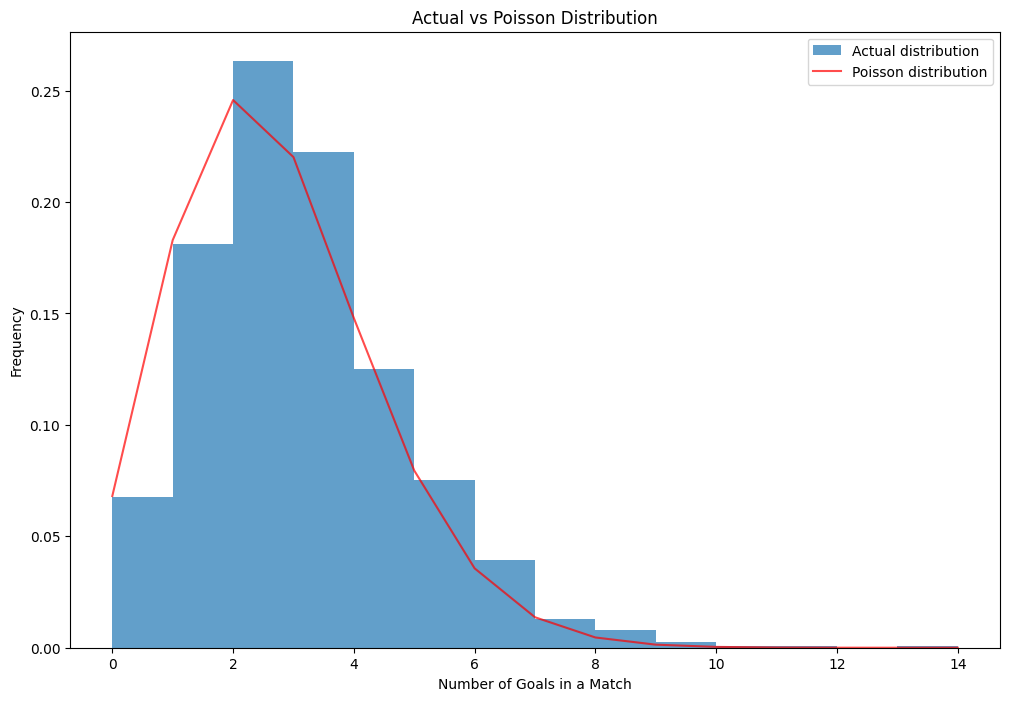

In [14]:
data = df2['total_score']

# Calculate the mean of the data as it will be the lambda (rate parameter) for the Poisson distribution
mu = data.mean()

# Create a range of numbers from 0 to the maximum number of goals in a match (this will be our x-axis)
k = np.arange(0, data.max()+1)

# Create a Poisson distribution with the mean obtained
poisson_pmf = poisson.pmf(k, mu)

plt.figure(figsize=(12,8))

# Plot the actual distribution of goals
plt.hist(data, bins=k, density=True, alpha=0.7, label='Actual distribution')

# Plot the Poisson distribution
plt.plot(k, poisson_pmf, 'r-', alpha=0.7, label='Poisson distribution')

plt.title('Actual vs Poisson Distribution')
plt.xlabel('Number of Goals in a Match')
plt.ylabel('Frequency')
plt.legend()

plt.show()

With the utilization of the given distribution, we can use the probabilities to predict the matches.

In [15]:
def calculate_match_probabilities(team_a_lambda, team_b_lambda, max_goals=6):
    # Create a matrix of zeros
    matrix = np.zeros((max_goals + 1, max_goals + 1))

    # Populate the matrix with probabilities
    for i in range(max_goals + 1):
        for j in range(max_goals + 1):
            matrix[i, j] = poisson.pmf(i, team_a_lambda) * poisson.pmf(j, team_b_lambda)

    # Calculate the total goals probabilities
    total_goals_prob = [np.sum(np.diag(matrix[::-1], k)) for k in range(-(max_goals-1), max_goals+1)]

    # Calculate the probability for the specific result
    draw_prob = np.sum(np.diag(matrix))
    away_prob = np.sum(np.triu(matrix, 1))
    local_prob = np.sum(np.tril(matrix, -1))

    return total_goals_prob, draw_prob, away_prob, local_prob


For instance, let's consider the inaugural match of the 2024 Euro between Germany and Scotland. Germany boasts an offensive power of 2.58, while Scotland 1.31.

Probability for Germany: 65.0 %
Probability for Scotland: 15.0 %
Probability for draw: 19.0 %


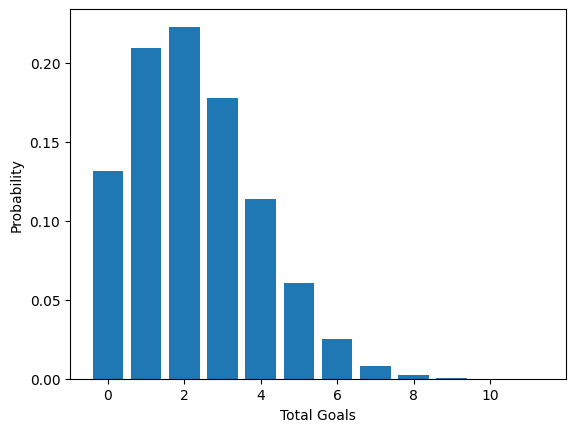

In [16]:
# Example usage
team_a_lambda = 2.581260 * 0.859073  
team_b_lambda = 0.739093 * 1.317341
total_goals_prob, draw_prob, away_prob, local_prob = calculate_match_probabilities(team_a_lambda, team_b_lambda)

# Print the results
'''print("Total goals probabilities:")
for goals, prob in enumerate(total_goals_prob):
    print(f'Probability of total {goals} goals: {prob}')'''


print(f"Probability for Germany: {round(local_prob,2)*100} %")
print(f"Probability for Scotland: {round(away_prob,2)*100} %")
print(f"Probability for draw: {round(draw_prob,2)*100} %")

import matplotlib.pyplot as plt
# Plot the distribution of possible total goals
plt.bar(range(len(total_goals_prob)), total_goals_prob)
plt.xlabel('Total Goals')
plt.ylabel('Probability')
plt.show()

Now it is time to validate if the probabilities given by the poisson distribution are accurate or not

In [17]:
df_euro=df2.copy()
# Function to apply to each row of the DataFrame
def apply_calculation(row):
    
    total_goals_prob, draw_prob, away_prob, local_prob = calculate_match_probabilities(row['XGhome'], row['XGaway'])
    return pd.Series({
        'total_goals_prob': total_goals_prob,
        'draw_prob': draw_prob,
        'away_prob': away_prob,
        'local_prob': local_prob
    })

# Apply the function to each row
calculated_variables = df_euro.apply(apply_calculation, axis=1)

# Concatenate the result with the original DataFrame
matches_df = pd.concat([df_euro, calculated_variables], axis=1)

df_euro[['total_goals_prob', 'draw_prob', 'away_prob', 'local_prob']] = df_euro[['XGhome','XGaway']].apply(apply_calculation, axis=1)

# Iterate over each row in the DataFrame
for index, row in df_euro.iterrows():
    # Iterate over each element in the 'total_goals_prob' list
    for i, prob in enumerate(row['total_goals_prob']):
        # Create new column with the name 'prob_index_goals_i' and assign the corresponding value
        df_euro.at[index, f'prob_index_goals_{i}'] = prob

<Figure size 1200x600 with 0 Axes>

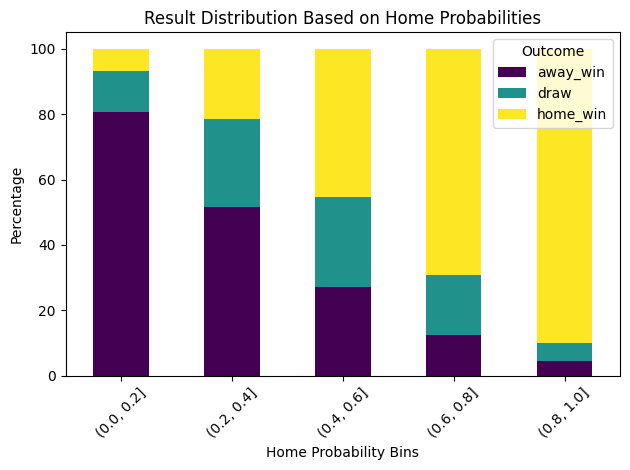

In [18]:
# Compute the actual outcome based on the home and away scores
df_euro['result'] = np.where(df_euro['home_score'] > df_euro['away_score'], 'home_win',
                                 np.where(df_euro['home_score'] == df_euro['away_score'], 'draw', 'away_win'))

df_euro['home_win_flag'] = np.where(df_euro['result']=='home_win', 1,0)
df_euro['draw_flag'] = np.where(df_euro['result']=='draw', 1,0)
df_euro['away_win_flag'] = np.where(df_euro['result']=='away_win', 1,0)
# Define bins for grouping based on predicted probabilities (adjust as needed)
bins = [0, 0.2, 0.4,0.6, 0.8,1]

# Create a new column indicating the bin for each match based on predicted probabilities
df_euro['probability_bin'] = pd.cut(df_euro['local_prob'], bins=bins)

# Group the DataFrame by the probability bins and compute the percentage of actual outcomes within each group
result_distribution = df_euro.groupby('probability_bin')['result'].value_counts(normalize=True).unstack() * 100

# Plotting the result distribution based on home probabilities
plt.figure(figsize=(12, 6))
result_distribution.plot(kind='bar', stacked=True, cmap='viridis')
plt.title('Result Distribution Based on Home Probabilities')
plt.xlabel('Home Probability Bins')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Outcome')
plt.tight_layout()

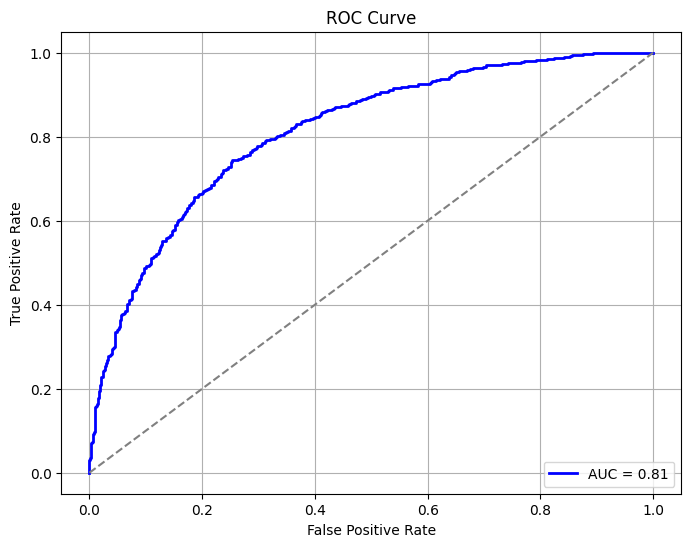

AUC: 0.81


In [19]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(df_euro['home_win_flag'], df_euro['local_prob'])

# Compute AUC
auc = roc_auc_score(df_euro['home_win_flag'], df_euro['local_prob'])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"AUC: {auc:.2f}")

It can be seen that the probabilities for home winning are working good.

In [20]:
# Create a new column indicating the bin for each match based on predicted probabilities
bins = [0, 0.15, 0.3,0.6,1]
df_euro['probability_bin'] = pd.cut(df_euro['away_prob'], bins=bins)

# Group the DataFrame by the probability bins and compute the percentage of actual outcomes within each group
result_distribution = df_euro.groupby('probability_bin')['result'].value_counts(normalize=True).unstack() * 100
print(result_distribution)
# Compute AUC
auc_away = roc_auc_score(df_euro['away_win_flag'], df_euro['away_prob'])

print(f"AUC: {auc_away:.2f}")

result            away_win       draw   home_win
probability_bin                                 
(0.0, 0.15]       7.984791  13.498099  78.517110
(0.15, 0.3]      25.454545  27.727273  46.818182
(0.3, 0.6]       53.740157  25.787402  20.472441
(0.6, 1.0]       88.513514   7.432432   4.054054
AUC: 0.82


It can be said the same for the away probabilities, 
so we can conclude that this predictions are relative good for the matches in Euro.

# 2024 Euro Prediction

Once we have the probabilities, we can finally use it to predict the results of the 2024 Euro. Let see it.

In [21]:
matches_data = [
    # Grupo A
    {"Grupo": "A", "Home_Team": "Germany", "Away_Team": "Scotland"},
    {"Grupo": "A", "Home_Team": "Hungary", "Away_Team": "Switzerland"},
    {"Grupo": "A", "Home_Team": "Germany", "Away_Team": "Hungary"},
    {"Grupo": "A", "Home_Team": "Scotland", "Away_Team": "Switzerland"},
    {"Grupo": "A", "Home_Team": "Switzerland", "Away_Team": "Germany"},
    {"Grupo": "A", "Home_Team": "Scotland", "Away_Team": "Hungary"},
    # Grupo B
    {"Grupo": "B", "Home_Team": "Spain", "Away_Team": "Croatia"},
    {"Grupo": "B", "Home_Team": "Italy", "Away_Team": "Albania"},
    {"Grupo": "B", "Home_Team": "Croatia", "Away_Team": "Albania"},
    {"Grupo": "B", "Home_Team": "Spain", "Away_Team": "Italy"},
    {"Grupo": "B", "Home_Team": "Albania", "Away_Team": "Spain"},
    {"Grupo": "B", "Home_Team": "Croatia", "Away_Team": "Italy"},
    # Grupo C
    {"Grupo": "C", "Home_Team": "Slovenia", "Away_Team": "Denmark"},
    {"Grupo": "C", "Home_Team": "Serbia", "Away_Team": "England"},
    {"Grupo": "C", "Home_Team": "Slovenia", "Away_Team": "Serbia"},
    {"Grupo": "C", "Home_Team": "Denmark", "Away_Team": "England"},
    {"Grupo": "C", "Home_Team": "England", "Away_Team": "Slovenia"},
    {"Grupo": "C", "Home_Team": "Denmark", "Away_Team": "Serbia"},
    # Grupo D
    {"Grupo": "D", "Home_Team": "Poland", "Away_Team": "Netherlands"},
    {"Grupo": "D", "Home_Team": "Austria", "Away_Team": "France"},
    {"Grupo": "D", "Home_Team": "Poland", "Away_Team": "Austria"},
    {"Grupo": "D", "Home_Team": "Netherlands", "Away_Team": "France"},
    {"Grupo": "D", "Home_Team": "Netherlands", "Away_Team": "Austria"},
    {"Grupo": "D", "Home_Team": "France", "Away_Team": "Poland"},
    # Grupo E
    {"Grupo": "E", "Home_Team": "Romania", "Away_Team": "Ukraine"},
    {"Grupo": "E", "Home_Team": "Belgium", "Away_Team": "Slovakia"},
    {"Grupo": "E", "Home_Team": "Slovakia", "Away_Team": "Ukraine"},
    {"Grupo": "E", "Home_Team": "Belgium", "Away_Team": "Romania"},
    {"Grupo": "E", "Home_Team": "Slovakia", "Away_Team": "Romania"},
    {"Grupo": "E", "Home_Team": "Ukraine", "Away_Team": "Belgium"},
    # Grupo F
    {"Grupo": "F", "Home_Team": "Turkey", "Away_Team": "Georgia"},
    {"Grupo": "F", "Home_Team": "Portugal", "Away_Team": "Czech Republic"},
    {"Grupo": "F", "Home_Team": "Georgia", "Away_Team": "Czech Republic"},
    {"Grupo": "F", "Home_Team": "Turkey", "Away_Team": "Portugal"},
    {"Grupo": "F", "Home_Team": "Georgia", "Away_Team": "Portugal"},
    {"Grupo": "F", "Home_Team": "Czech Republic", "Away_Team": "Turkey"},
]

# Create a dataframe
matches_df = pd.DataFrame(matches_data)

In [22]:
# Merge the dataframes based on the "Home Team" column and rename columns with prefix
merged_df = pd.merge(matches_df, attdef[["Team", "att", "def"]].add_prefix('Home_'),left_on="Home_Team", right_on="Home_Team", how="left")
group_matches = pd.merge(merged_df, attdef[["Team", "att", "def"]].add_prefix('Away_'),left_on="Away_Team", right_on="Away_Team", how="left")

In [23]:
#Computing the expected goals
group_matches['XGhome']=group_matches['Home_att']*group_matches['Away_def']
group_matches['XGaway']=group_matches['Home_def']*group_matches['Away_att']

group_matches[['total_goals_prob', 'draw_prob', 'away_prob', 'local_prob']] = group_matches[['XGhome','XGaway']].apply(apply_calculation, axis=1)
group_matches.drop("total_goals_prob",axis=1, inplace=True)

In [24]:
# Define a function to determine the result based on probabilities
def determine_result_random(row):
    random_number = np.random.random()
    if random_number < row["draw_prob"]:
        return "Draw"
    elif random_number < row["draw_prob"] + row["away_prob"]:
        return row["Away_Team"]
    else:
        return row["Home_Team"]
    

def determine_result(row):
    max_prob = max(row["draw_prob"], row["away_prob"], row["local_prob"])
    if row["draw_prob"] == max_prob:
        return "Draw"
    elif row["away_prob"] == max_prob:
        return row["Away_Team"]
    else:
        return row["Home_Team"]
    
def determine_result_knockout(row):
    if row["away_prob"] >row["home_prob"]:
        return row["Away_Team"]
    else:
        return row["Home_Team"]
    
def determine_result_knockout_random(row):
    random_number = np.random.random()
    if random_number < row["draw_prob"]:
        random_number2 = np.random.random()
        if random_number < 0.5:
            return row["Away_Team"]
        else:
            return row["Home_Team"]
    elif random_number < row["draw_prob"] + row["away_prob"]:
        return row["Away_Team"]
    else:
        return row["Home_Team"]
    
# Apply the function to create the "Results" column
group_matches["Result"] = group_matches.apply(determine_result, axis=1)


We can see the predictions for each match, based on the expexted goals, we simulate the number of goals scored by each team in a match.

In [25]:
group_matches[group_matches.Grupo=="A"][["Home_Team","Away_Team", "local_prob","draw_prob","away_prob","XGhome","XGaway","Result"]]

,Home_Team,Away_Team,local_prob,draw_prob,away_prob,XGhome,XGaway,Result
0,Germany,Scotland,0.647934,0.191033,0.153192,2.217490,0.973638,Germany
1,Hungary,Switzerland,0.256316,0.251095,0.491217,1.067382,1.580824,Switzerland
2,Germany,Hungary,0.664228,0.180164,0.144909,2.358002,1.003952,Germany
3,Scotland,Switzerland,0.263436,0.260428,0.475153,1.035153,1.486623,Switzerland
4,Switzerland,Germany,0.238047,0.214158,0.542545,1.279000,2.028327,Germany
5,Scotland,Hungary,0.369335,0.278607,0.351590,1.203402,1.166927,Scotland


In [26]:
group_matches[group_matches.Grupo=="B"][["Home_Team","Away_Team", "local_prob","draw_prob","away_prob","XGhome","XGaway","Result"]]

,Home_Team,Away_Team,local_prob,draw_prob,away_prob,XGhome,XGaway,Result
6,Spain,Croatia,0.526335,0.248955,0.223252,1.612466,0.954341,Spain
7,Italy,Albania,0.680615,0.221054,0.096250,1.732209,0.477044,Italy
8,Croatia,Albania,0.666548,0.217790,0.113112,1.797211,0.578266,Croatia
9,Spain,Italy,0.461269,0.279594,0.258626,1.330214,0.919824,Spain
10,Albania,Spain,0.053148,0.138854,0.796058,0.459740,2.414183,Spain
11,Croatia,Italy,0.310482,0.294210,0.395027,0.990263,1.156966,Italy


In [27]:
group_matches[group_matches.Grupo=="C"][["Home_Team","Away_Team", "local_prob","draw_prob","away_prob","XGhome","XGaway","Result"]]

,Home_Team,Away_Team,local_prob,draw_prob,away_prob,XGhome,XGaway,Result
12,Slovenia,Denmark,0.194014,0.267594,0.537599,0.754194,1.455328,Denmark
13,Serbia,England,0.154765,0.205936,0.634500,0.877082,2.018616,England
14,Slovenia,Serbia,0.271654,0.256830,0.470404,1.084522,1.513703,Serbia
15,Denmark,England,0.225589,0.273130,0.500620,0.843258,1.403778,England
16,England,Slovenia,0.685106,0.204319,0.107017,1.910978,0.594894,England
17,Denmark,Serbia,0.469950,0.254150,0.274677,1.537301,1.111945,Denmark


In [28]:
group_matches[group_matches.Grupo=="D"][["Home_Team","Away_Team", "local_prob","draw_prob","away_prob","XGhome","XGaway","Result"]]

,Home_Team,Away_Team,local_prob,draw_prob,away_prob,XGhome,XGaway,Result
18,Poland,Netherlands,0.194834,0.220202,0.581330,1.006125,1.910357,Netherlands
19,Austria,France,0.146457,0.203709,0.644950,0.840269,2.026080,France
20,Poland,Austria,0.402358,0.261473,0.335274,1.386166,1.241604,Poland
21,Netherlands,France,0.332330,0.253581,0.412872,1.292855,1.470596,France
22,Netherlands,Austria,0.618425,0.206487,0.169923,2.044847,0.964643,Netherlands
23,France,Poland,0.609349,0.218716,0.168522,1.892823,0.876403,France


In [29]:
group_matches[group_matches.Grupo=="E"][["Home_Team","Away_Team", "local_prob","draw_prob","away_prob","XGhome","XGaway","Result"]]

,Home_Team,Away_Team,local_prob,draw_prob,away_prob,XGhome,XGaway,Result
24,Romania,Ukraine,0.304357,0.292223,0.403117,0.984930,1.180462,Ukraine
25,Belgium,Slovakia,0.663693,0.202113,0.129646,2.000022,0.744810,Belgium
26,Slovakia,Ukraine,0.277760,0.281074,0.440696,0.968629,1.298772,Ukraine
27,Belgium,Romania,0.623605,0.223064,0.150604,1.817832,0.757344,Belgium
28,Slovakia,Romania,0.323439,0.290972,0.385282,1.036064,1.159086,Romania
29,Ukraine,Belgium,0.185572,0.238872,0.573654,0.848615,1.699514,Belgium


In [30]:
group_matches[group_matches.Grupo=="F"][["Home_Team","Away_Team", "local_prob","draw_prob","away_prob","XGhome","XGaway","Result"]]

,Home_Team,Away_Team,local_prob,draw_prob,away_prob,XGhome,XGaway,Result
30,Turkey,Georgia,0.498882,0.249502,0.250165,1.599911,1.054860,Turkey
31,Portugal,Czech Republic,0.580246,0.232441,0.184979,1.763472,0.880434,Portugal
32,Georgia,Czech Republic,0.206041,0.250528,0.542070,0.876758,1.597465,Czech Republic
33,Turkey,Portugal,0.145110,0.196014,0.652653,0.881782,2.121698,Portugal
34,Georgia,Portugal,0.084244,0.160318,0.745128,0.642337,2.344155,Portugal
35,Czech Republic,Turkey,0.426017,0.258781,0.314197,1.445867,1.203589,Czech Republic


By running numerous simulations, we can estimate the probabilities of different outcomes for each match.
We simulate each match multiple times to predict the likely outcomes and the points each team might accumulate. The table presented below illustrates the predicted probabilities for each team to conclude the group stage in a particular position.

In [31]:
# Define a function to calculate points based on match results
def calculate_points(result, home_team, team):
    if result == "Draw":
        return 1
    elif result == home_team:
        return 3
    elif result == team:
        return 0

In [32]:
# Simulate match results and calculate standings
num_simulations = 10000  # Number of simulations
standings_list = []  # List to store standings for each simulation

for _ in range(num_simulations):
    # Apply the function to create the "Results" column
    group_matches["Result"] = group_matches.apply(determine_result_random, axis=1)
    # Apply the function to create the "Points" column for both Home and Away teams
    group_matches["Points_Home"] = group_matches.apply(lambda row: calculate_points(row["Result"], row["Home_Team"], row["Away_Team"]), axis=1)
    group_matches["Points_Away"] = group_matches.apply(lambda row: calculate_points(row["Result"], row["Away_Team"], row["Home_Team"]), axis=1)
    # Create a dataframe to store points for each teams
    standings = pd.DataFrame(columns=["Grupo","Team", "Points"])
    # Concatenate Home and Away points by group
    for group_name, group_data in group_matches.groupby("Grupo"):
        group_points_df = pd.DataFrame(columns=["Team", "Points"])
        for team in set(group_data["Home_Team"]).union(set(group_data["Away_Team"])):
            home_points = group_data.loc[group_data["Home_Team"] == team, "Points_Home"].sum()
            away_points = group_data.loc[group_data["Away_Team"] == team, "Points_Away"].sum()
            total_points = home_points + away_points
            group_points_df = group_points_df._append({"Team": team, "Points": total_points}, ignore_index=True)
        group_points_df = group_points_df.sort_values(by=["Points"], ascending=False).reset_index(drop=True)
        group_points_df["Grupo"] = group_name
        group_points_df["Rank"] = range(1, len(group_points_df) + 1)
        group_points_df["Qualified_1"]=np.where(group_points_df["Rank"]==1,1,0)
        group_points_df["Qualified_2"]=np.where(group_points_df["Rank"]==2,1,0)
        group_points_df["Qualified_3"]=np.where(group_points_df["Rank"]==3,1,0)
        group_points_df["Qualified_4"]=np.where(group_points_df["Rank"]==4,1,0)
        standings = pd.concat([standings, group_points_df], ignore_index=True)
        standings_list.append(standings)

In [33]:
standings = pd.concat(standings_list).groupby(["Team","Grupo"])[["Qualified_1","Qualified_2","Qualified_3","Qualified_4"]].mean().reset_index().sort_values(by=["Grupo","Qualified_1"], ascending=[True,False])
standings_style = standings.style.background_gradient(cmap='Greens')
standings_style

,Team,Grupo,Qualified_1,Qualified_2,Qualified_3,Qualified_4
9,Germany,A,0.654400,0.213600,0.097100,0.034900
21,Switzerland,A,0.186000,0.340300,0.288300,0.185400
10,Hungary,A,0.086800,0.259400,0.324600,0.329200
16,Scotland,A,0.072800,0.186700,0.290000,0.450500
20,Spain,B,0.494200,0.302800,0.155000,0.048000
3,Croatia,B,0.272700,0.306500,0.322000,0.098800
11,Italy,B,0.214200,0.319100,0.328500,0.138200
0,Albania,B,0.018900,0.071600,0.194500,0.715000
6,England,C,0.569800,0.245800,0.126000,0.058400
5,Denmark,C,0.184700,0.321500,0.287900,0.205900


As we can see, the teams that are more likely to win its respecctive group are Portugal, Belgium and England.
And the team which have more difficult to pass the round is Albania.

# Conclusion
Predicting football match outcomes is inherently uncertain, but statistical models like the Poisson distribution offer a structured approach to quantify this uncertainty. Our predictions for the 2024 UEFA Euro provide a glimpse into possible outcomes based on historical performance data. As with all models, the key is to continually refine our approach as new data becomes available.